In [157]:
! git clone https://www.github.com/ildoonet/tf-pose-estimation
! cd tf-pose-estimation && python setup.py install  # Or, `pip install -e .`

! apt-get install swig && cd tf-pose-estimation/tf_pose/pafprocess && swig -python -c++ pafprocess.i && python3 setup.py build_ext --inplace

! git clone https://github.com/adamrehn/slidingwindow.git
! cd slidingwindow && python setup.py install

! wget -O tf-pose-estimation/models/graph/cmu/graph_opt.pb http://download692.mediafire.com/fol65zt9iwwg/qlzzr20mpocnpa3/graph_opt.pb

fatal: destination path 'tf-pose-estimation' already exists and is not an empty directory.


KeyboardInterrupt: ignored

In [0]:
import sys
sys.path.append('tf-pose-estimation/')

In [132]:
! wget https://getfile.dokpub.com/yandex/get/https://yadi.sk/d/nWHh53OXDGoYqw
! unrar x nWHh53OXDGoYqw ./
! sudo rm nWHh53OXDGoYqw


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from nWHh53OXDGoYqw

Creating    ./data                                                    OK
Extracting  ./data/IMG_8266.MOV                                            0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19%  OK 
Extracting  ./data/IMG_8267.MOV                                           20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33%  OK 
Extracting  ./data/IMG_8268.MOV                                           33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43%  OK 
Extracting  ./data/pushes3.mp4                                            43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 

In [159]:
import argparse
import sys
import time
import matplotlib.pyplot as plt
import os
import pandas as pd
from tqdm import tqdm_notebook
from tf_pose import common
import cv2
import numpy as np
from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path, model_wh

def captureCoords(model, args, offset=0, nonNullCounts=0, takeFrame = 5):

  '''
  Returns coordinates of body parts after applying pose estimation
  '''
  cap = cv2.VideoCapture(args['video'])
  ret, image = cap.read()
  frames = 0
  fullCoords = []

  while ret:
      ret, image = cap.read()

      t = time.time()
      if frames % takeFrame == 0 and frames >= offset:
        humans = model.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=args['resize_out_ratio'])
        allcords = list(np.zeros(((17+1)*2)))
        if len(humans) > 0:
          for substr in str(humans[0]).split('BodyPart:'):
            try:
              cat = int(substr.split('-')[0])
              li, ri = substr.index('('), substr.index(')')
              coords = substr[li+1:ri-1].split(', ')
              allcords[cat*2], allcords[cat*2 + 1] = float(coords[0]), float(coords[1])
            except:
              pass
        fullCoords.append(allcords)
        elapsed = time.time() - t
      frames += 1
      if frames >= nonNullCounts+offset and nonNullCounts > 0:
        break

      if cv2.waitKey(0) & 0xFF == ord('q'):
          break

  # When everything is done, release the capture
  cap.release()
  cv2.destroyAllWindows()

  # Coordinates of each frame in the matrix
  return fullCoords



args = {'video': 'videos/pushes.mp4',
        'model': 'cmu',
        'resize': '432x368',
        'resize_out_ratio': 4.0}

# loading OpenPose model
w, h = model_wh(args['resize'])
if w == 0 or h == 0:
    model = TfPoseEstimator(get_graph_path(args['model']), target_size=(432, 368));
else:
    model = TfPoseEstimator(get_graph_path(args['model']), target_size=(w, h));

[2020-03-12 15:42:27,375] [TfPoseEstimator] [INFO] loading graph from /usr/local/lib/python3.6/dist-packages/tf_pose-0.1.1-py3.6-linux-x86_64.egg/tf_pose_data/graph/cmu/graph_opt.pb(default size=432x368)
2020-03-12 15:42:27,375 INFO loading graph from /usr/local/lib/python3.6/dist-packages/tf_pose-0.1.1-py3.6-linux-x86_64.egg/tf_pose_data/graph/cmu/graph_opt.pb(default size=432x368)


TfPoseEstimator/Openpose/concat_stage7/axis
TfPoseEstimator/Mconv7_stage6_L2/biases
TfPoseEstimator/Mconv7_stage6_L2/weights
TfPoseEstimator/Mconv6_stage6_L2/biases
TfPoseEstimator/Mconv6_stage6_L2/weights
TfPoseEstimator/Mconv5_stage6_L2/biases
TfPoseEstimator/Mconv5_stage6_L2/weights
TfPoseEstimator/Mconv4_stage6_L2/biases
TfPoseEstimator/Mconv4_stage6_L2/weights
TfPoseEstimator/Mconv3_stage6_L2/biases
TfPoseEstimator/Mconv3_stage6_L2/weights
TfPoseEstimator/Mconv2_stage6_L2/biases
TfPoseEstimator/Mconv2_stage6_L2/weights
TfPoseEstimator/Mconv1_stage6_L2/biases
TfPoseEstimator/Mconv1_stage6_L2/weights
TfPoseEstimator/Mconv7_stage6_L1/biases
TfPoseEstimator/Mconv7_stage6_L1/weights
TfPoseEstimator/Mconv6_stage6_L1/biases
TfPoseEstimator/Mconv6_stage6_L1/weights
TfPoseEstimator/Mconv5_stage6_L1/biases
TfPoseEstimator/Mconv5_stage6_L1/weights
TfPoseEstimator/Mconv4_stage6_L1/biases
TfPoseEstimator/Mconv4_stage6_L1/weights
TfPoseEstimator/Mconv3_stage6_L1/biases
TfPoseEstimator/Mconv3_st

In [0]:
# capturing coordinates and gathering training dataset
takeFrame = 5
X = pd.DataFrame()
Y = pd.DataFrame()
for path in tqdm_notebook(os.listdir('data/')[:-1]):
  args['video'] = 'data/' + path
  videoTargets = pd.read_csv('csvs/' + path.split('.')[0] + '.csv')

  offset = int(videoTargets['frame'][0].split('.')[0])
  nonNullCounts = len(videoTargets['label'].dropna()) * takeFrame
  # run coordinate capture via OpenPose
  fullCoords = captureCoords(model, args, offset = offset, nonNullCounts=nonNullCounts, takeFrame = takeFrame)

  # generate features and append to the full dataset
  x = pd.DataFrame(fullCoords)
  x = pd.concat([x, x - x.shift(1).fillna(0)], axis = 1)
  X = pd.concat([X, x], axis = 0)

  # append targets to the full label set
  y = videoTargets['label'].dropna().map(int)
  Y = pd.concat([Y, y], axis = 0)

In [137]:
# sanity check
print(X.shape, Y.shape)

(280, 108) (280, 1)


In [139]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

Xtr, Xval, ytr, yval = train_test_split(X.values, Y.values.reshape(-1), shuffle = False, train_size = 0.6)
rfc = RandomForestClassifier()
rfc.fit(Xtr, ytr)
ypred = rfc.predict(Xval)
print(accuracy_score(yval, ypred))

0.44642857142857145


In [140]:
yval

array([1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1.,
       1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1.,
       1., 0., 1., 1., 0., 1., 1., 0., 0., 1.])

In [141]:
ypred

array([0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 2., 2., 2., 2., 0., 0., 0., 0.,
       2., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 2., 0., 0., 0., 2., 0.,
       1., 2., 1., 1., 2., 0., 0., 2., 0., 1., 2., 2., 1., 1., 2., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 2., 1., 0.])

## Count movements

In [0]:
def moveCount(labels):
    k = 0
    for i in range(1, len(labels)):
        if labels[i-1] == 0 and labels[i] == 1:
            k+=1
    return k

In [143]:
moveCount(yval)

15

In [144]:
moveCount(ypred)

10

## Evaluation

In [0]:
labels = pd.read_csv('csvs/IMG_8267.csv').dropna()
labels['label'] = labels['label'].map(int)
offset = int(labels['frame'][0].split('.')[0])

In [0]:
args = {'video': 'data/IMG_8267.MOV',
        'model': 'cmu',
        'resize': '432x368',
        'resize_out_ratio': 4.0}

fullCoords = captureCoords(model, args, offset = offset, nonNullCounts=len(labels) * 5)

In [0]:
X = pd.DataFrame(fullCoords)
X = pd.concat([X, X.shift(1).fillna(0), X.shift(2).fillna(0)], axis = 1)

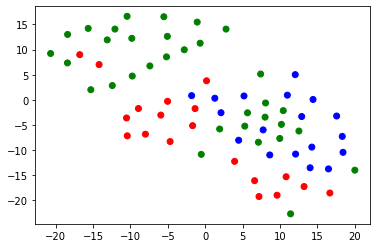

In [156]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
min_len = np.min([len(labels), len(X)])
labels = labels.iloc[:min_len, :]
d = TSNE(2).fit_transform(X[:min_len])

import matplotlib.pyplot as plt
plt.scatter(d[:, 0], d[:, 1], c = labels['label'].map({0: 'r', 1: 'b', 2: 'g'}))

In [150]:
# Prediction on test

ypred = rfc.predict(X)
print(accuracy_score(labels['label'], ypred))

0.5571428571428572


In [151]:
ypred

array([1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 2., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 2., 0., 0., 1., 2., 0., 0., 1., 1., 2., 0., 0., 1.,
       1., 1., 0., 0., 1., 2., 0., 0., 0., 1., 1., 1., 0., 0., 1., 2., 0.,
       0., 0.])

In [152]:
labels['label'].values

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 1])

In [153]:
moveCount(labels['label'])

8

In [154]:
moveCount(ypred)

8